In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HOOMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0]  Tesla P100-PCIE-16GB  56 SM_6.0 @ 1.33 GHz, 16280 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 23708


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [5000, 10000]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
# Randomly place 5000 binders within the inscribed cube
number_of_binders = 5000
binder_positions = (np.random.random((number_of_binders, 3))-0.5) * (inscribed_cube_length-0.5)

In [10]:
# Parse force dictionary
with open("force_dict_binders.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

In [11]:
# Parse particle/bond types
bond_types = force_dict['Bonded forces'].keys()
angle_types = force_dict['Angular forces'].keys()
particle_types = force_dict['Non-bonded forces']['Attraction']['Matrix'].keys()

In [12]:
# Populate snapshot with the generated chains/binders
build.set_chains(snapshot, monomer_positions, chromosome_sizes,
                 bond_type_list=list(bond_types), angle_type_list=list(angle_types),
                 monomer_type_list=list(particle_types)[:-1])

build.set_binders(snapshot, binder_positions, binder_type_list=list(particle_types)[-1:])

In [13]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

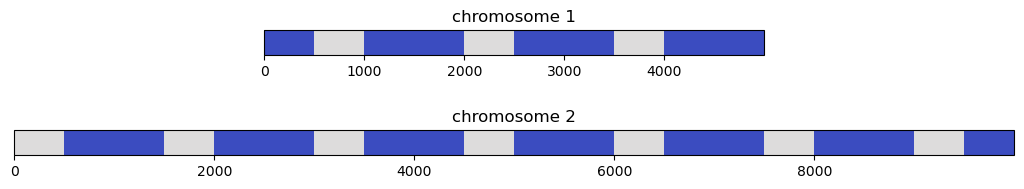

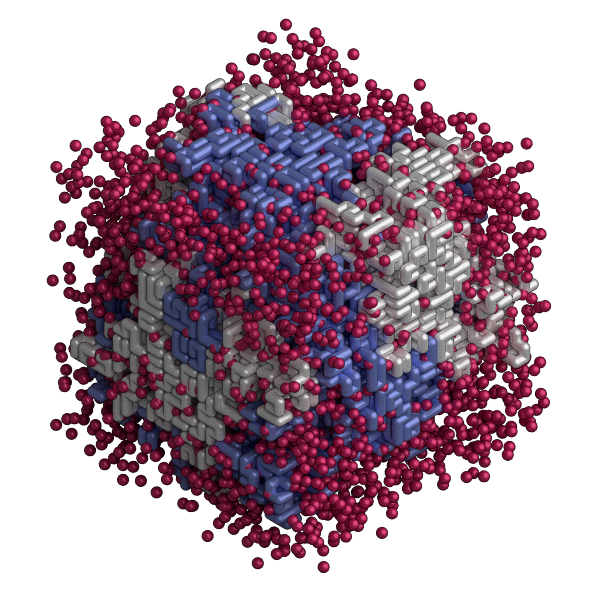

In [14]:
# Assign and visualize domains in 1D/3D
snapshot.particles.typeid[:number_of_monomers] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot, cmap="coolwarm")
render.fresnel(snapshot, show_compartments=True, cmap="coolwarm")

In [15]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [16]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [17]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [18]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [19]:
# Set spherical confining wall
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

In [20]:
# Set attractive/DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

Setting up DPD with the conservative force contribution disabled


In [21]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + confinement_forces \
            + dpd_forces + attraction_forces

In [22]:
# Setup DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.11/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [23]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [24]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           1873.93351     0:01:41.391004           1.15278          
       20000           2221.56436     0:01:21.023986           1.07585          
       30000           2258.53244     0:01:15.270117           1.05891          
       40000           2210.44834     0:01:12.383506           1.04703          
       50000           2147.06966     0:01:09.862661           1.03658          
       60000           2107.00002     0:01:06.445182           1.03775          
       70000           2067.80024     0:01:02.868742           1.03216          
       80000           2021.57732     0:00:59.359589           1.02479          
       90000           1984.33837     0:00:55.434094           1.02348          
      100000           1957.37622     0:00:51.088799           1.02975          
      110000           1931.51566     0:00:46.595532           1.02118          
      120000           1904.

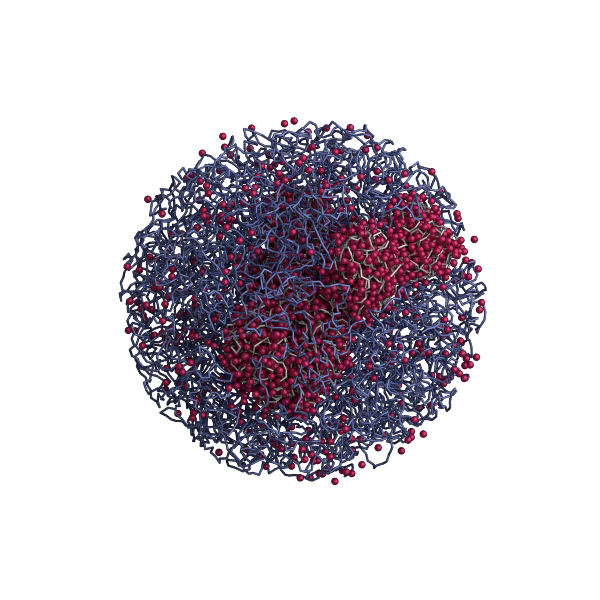

In [25]:
# Visualize equilibrated domains+binders in 3D
snapshot_equilibrated = system.state.get_snapshot()
render.fresnel(snapshot_equilibrated, show_compartments=True, cmap="coolwarm", rescale_backbone_bonds=0.3)